In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
import numpy as np
from scipy.stats import gaussian_kde
sns.set_theme(style='whitegrid')

In [2]:
model_path = './log_SGD_continue_1e-4/transformer_29_map0.9159278553764464_acc0.5036038160324097.pth'

# VAL SET

In [3]:
with open('./log_SGD_continue_1e-4/val_set_distances.pkl', 'rb') as f:
    (inter_class_distances, intra_class_distances) = pickle.load(f)

In [14]:
max_value_of_both = max(max(inter_class_distances), max(intra_class_distances))
min_value_of_both = min(min(inter_class_distances), min(intra_class_distances))

bin_size = 1e-7
bins = np.arange(min_value_of_both, max_value_of_both + bin_size, bin_size)

intra_hist, _ = np.histogram(intra_class_distances, bins=bins)
inter_hist, _ = np.histogram(inter_class_distances, bins=bins)

In [23]:
np.arange(0,7,1)

array([0, 1, 2, 3, 4, 5, 6])

In [27]:
bins = [0, 1, 2, 3, 4, 5, 6]
intra_hist = [0, 2, 3, 1, 0, 0, 0]
inter_hist = [0, 0, 0, 2, 1, 3, 2]
bin_size = 1

In [15]:
tp = 0
tn = np.sum(inter_hist)
total = np.sum(intra_hist) + tn
accs = np.array([]) 
for i, bin in enumerate(bins[:-1]):
    num_intra = intra_hist[i]
    num_inter = inter_hist[i]
    tp += num_intra
    tn -= num_inter
    acc = (tp + tn) / total
    accs = np.append(accs, acc)

# find the index with the highest accuracy
max_acc_index = np.argmax(accs)
optimal_thresh = bins[max_acc_index] + bin_size

# find the sum of intra_hist from max_acc_index to the end
fn = np.sum(intra_hist[max_acc_index+1:])
# find the sum of inter_hist from the beginning to max_acc_index
fp = np.sum(inter_hist[:max_acc_index])

intersection_area = fn + fp

print(optimal_thresh, accs[max_acc_index], intersection_area)

0.0009468894954681616 0.964346795835699 51423


## checking if we add the two distributions in val set tgt what the graph is like

In [16]:
added_distances = inter_class_distances + intra_class_distances

kde = gaussian_kde(added_distances)
x = np.linspace(np.min(added_distances), np.max(added_distances), num=2000)
kde_plot = kde(x)
gradient = np.gradient(kde_plot)
# Find the indices where the gradient changes sign (stationary points)
stationary_indices = np.where(np.diff(np.sign(gradient)))[0]

In [20]:
delta = optimal_thresh - x[stationary_indices][1]
delta

0.0001573937206284751

Text(0.004411339270882308, 525.42, 'O-S Delta: 0.0001573937206284751')

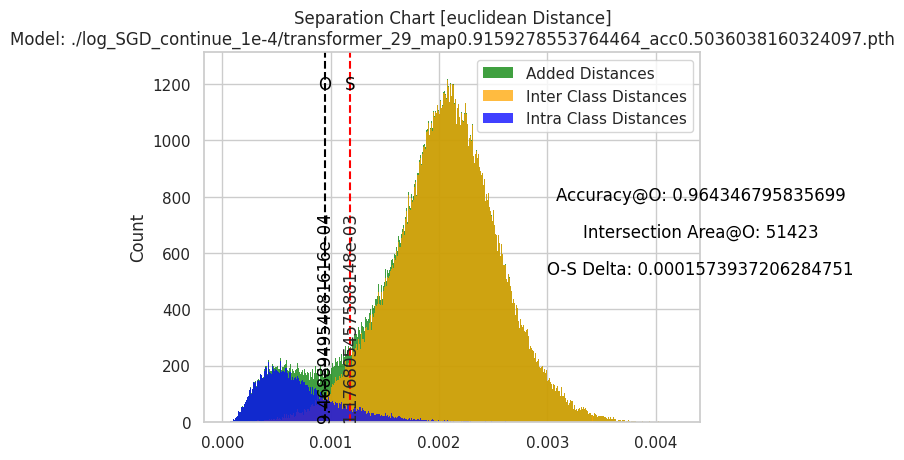

In [32]:
# Plot the histogram for inter_class_distances (Dissimilar) with orange color
sns.histplot(added_distances, color='green', label='Added Distances', binwidth=1e-6, binrange=(min_value_of_both, max_value_of_both))

sns.histplot(inter_class_distances, color='orange', label='Inter Class Distances', binwidth=1e-6, binrange=(min_value_of_both, max_value_of_both))
# Plot the histogram for intra_class_distances (Similar) with blue color
sns.histplot(intra_class_distances, color='blue', label='Intra Class Distances', binwidth=1e-6, binrange=(min_value_of_both, max_value_of_both))
plt.title(f'Separation Chart [euclidean Distance]\nModel: {model_path}')
plt.legend()

plt.axvline(x[stationary_indices][1], color='red', linestyle='--')
plt.text(x[stationary_indices][1], 0, f'{x[stationary_indices][1]:.15e}', rotation=90, verticalalignment='bottom', horizontalalignment='center')
plt.text(x[stationary_indices][1], plt.ylim()[1] * 0.9, 'S', color='black', ha='center')

plt.axvline(x=optimal_thresh, color='black', linestyle='--', label='Intersection Point')
plt.text(optimal_thresh, 0, f'{optimal_thresh:.15e}', color='black', rotation=90, verticalalignment='bottom', horizontalalignment='center')
plt.text(optimal_thresh, plt.ylim()[1] * 0.9, 'O', color='black', ha='center')

plt.text(plt.xlim()[1], plt.ylim()[1] * 0.6, f'Accuracy@O: {accs[max_acc_index]}', color='black', ha='center')
plt.text(plt.xlim()[1], plt.ylim()[1] * 0.5, f'Intersection Area@O: {intersection_area}', color='black', ha='center')
plt.text(plt.xlim()[1], plt.ylim()[1] * 0.4, f'O-S Delta: {delta}', color='black', ha='center')

In [25]:
delta

0.0001573937206284751

In [30]:
stationary_pt_xs[1]

0.0011768054575881477

In [31]:
stationary_pt_xs[1]+delta

0.0013341991782166228

# TEST SET

In [24]:
with open('./log_SGD_continue_1e-4/collated_test_set_distances.pkl', 'rb') as f:
    collated_distances = pickle.load(f)

In [26]:
kde = gaussian_kde(collated_distances)
x = np.linspace(np.min(collated_distances), np.max(collated_distances), num=10000)
kde_plot = kde(x)

In [27]:
gradient = np.gradient(kde_plot)
# Find the indices where the gradient changes sign (stationary points)
stationary_indices = np.where(np.diff(np.sign(gradient)))[0]
stationary_indices

array([1314, 3060, 5756])

In [28]:
stationary_pt_xs = x[stationary_indices]

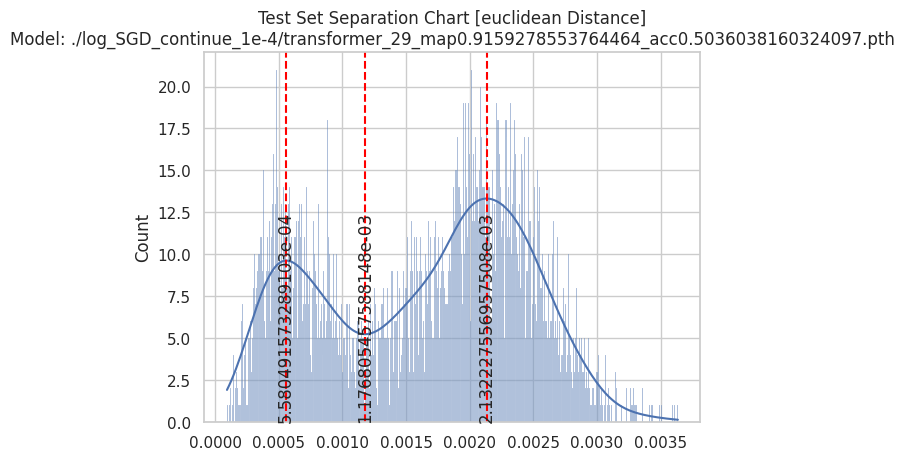

In [18]:
sns.histplot(collated_distances, bins=500, kde=True)
plt.title(f'Test Set Separation Chart [euclidean Distance]\nModel: {model_path}')
for stationary_pt_x in stationary_pt_xs:
    plt.axvline(stationary_pt_x, color='red', linestyle='--')
    plt.text(stationary_pt_x, 0, f'{stationary_pt_x:.15e}', rotation=90, verticalalignment='bottom', horizontalalignment='center')